In [1]:
%matplotlib inline


In [125]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from lightkurve import TessLightCurveFile
from astropy.coordinates import SkyCoord
import astropy.units as u
import lightkurve

import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from astropy.stats import BoxLeastSquares
import pandas as pd

In [3]:
print(xo.__version__)
print(pm.__version__)

0.1.6
3.6


In [4]:
target = 'l 98-59'
tpf_all = lightkurve.search_targetpixelfile(target).download_all()

In [5]:
tpf1, tpf2, tpf3 = tpf_all[0:3]

In [101]:
tpf3.sector

8

In [6]:
texp = tpf1.hdu[1].header['FRAMETIM'] * tpf1.hdu[1].header["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
ref_time = 0.5 * (tpf1.time.min() + tpf3.time.max())



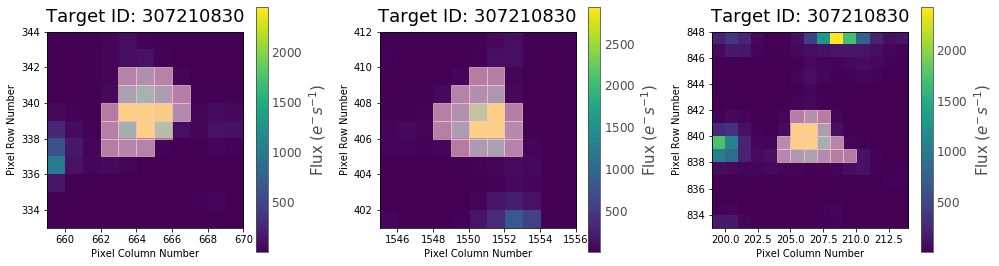

In [105]:
fig, axes = plt.subplots(1, 3, figsize=[14,4])
for i, tpf in enumerate(tpf_all[0:3]):

    pix_mask = tpf.create_threshold_mask(threshold=3.7)
    tpf.plot(aperture_mask=pix_mask, frame=2000, ax=axes[i])
plt.tight_layout()
fig.savefig('pixmask_3.pdf')

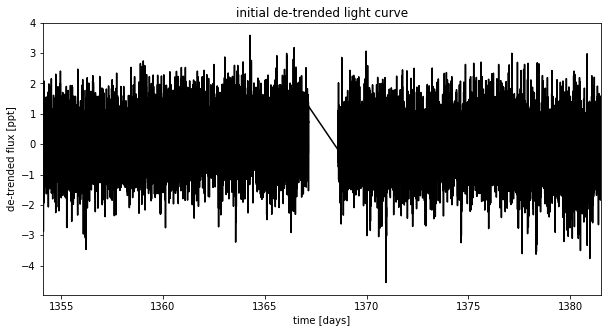

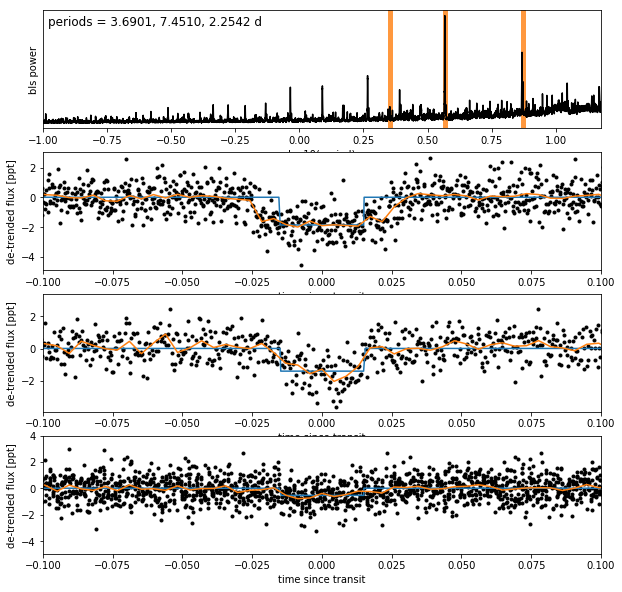

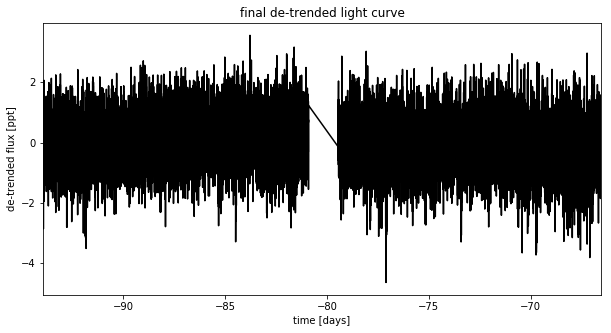

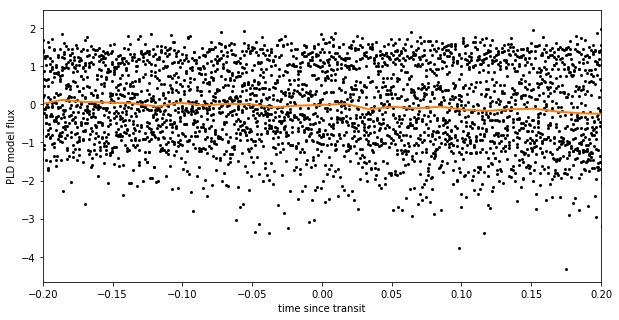

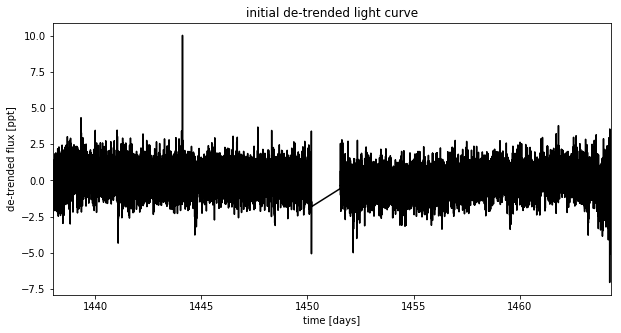

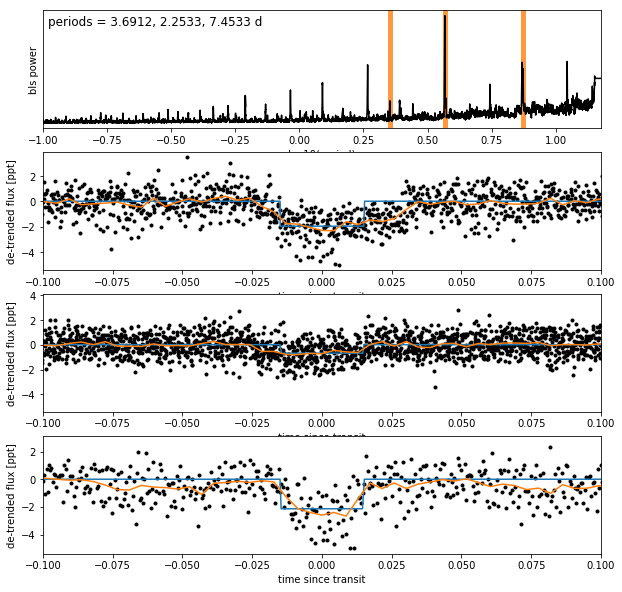

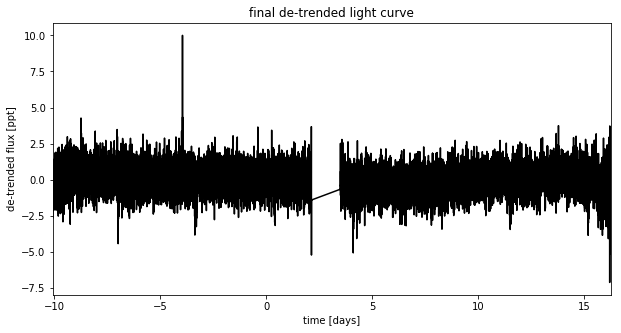

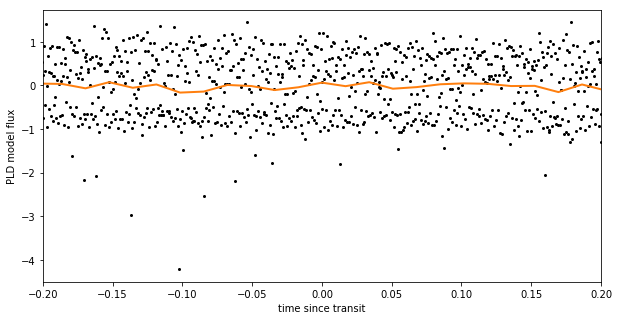

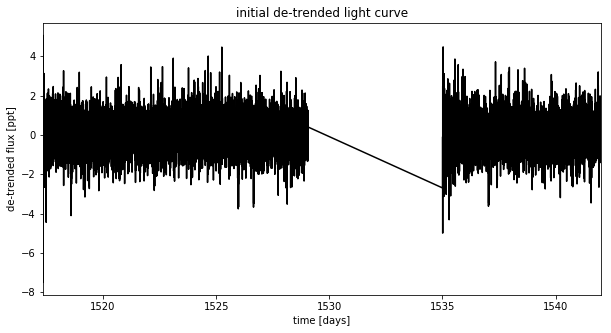

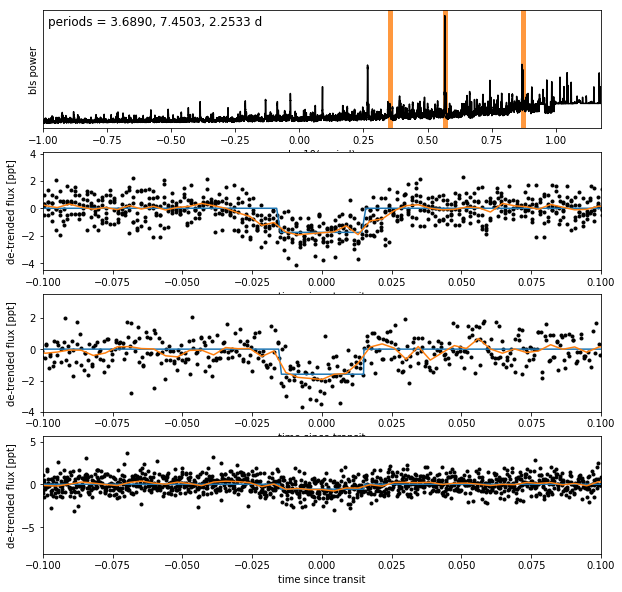

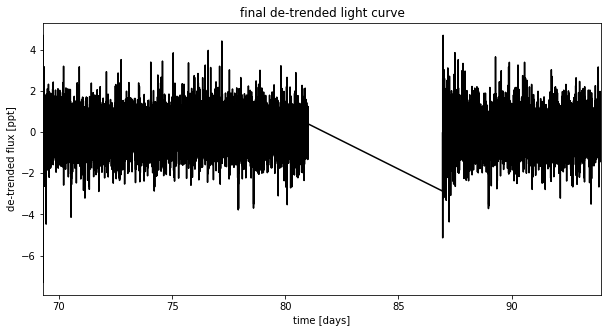

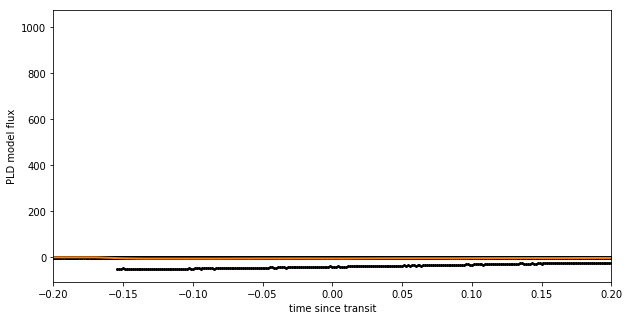

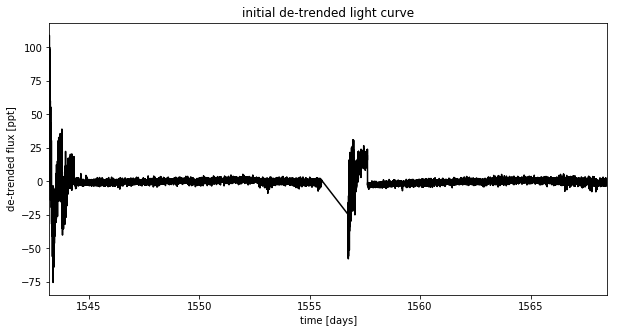

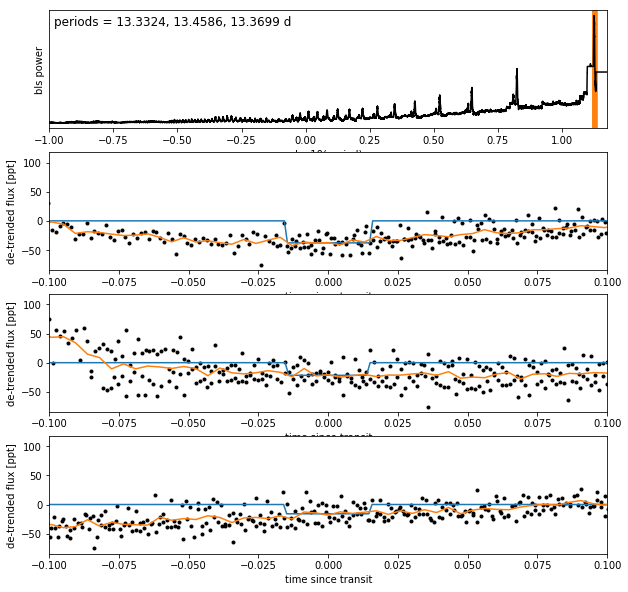

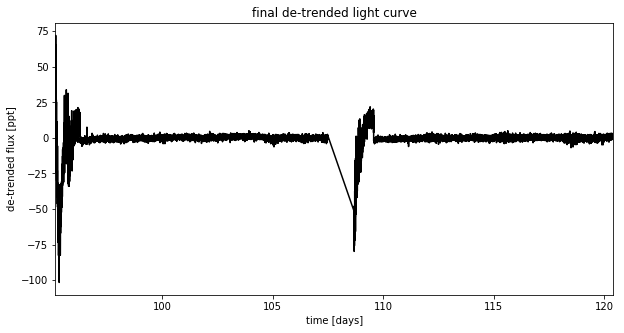

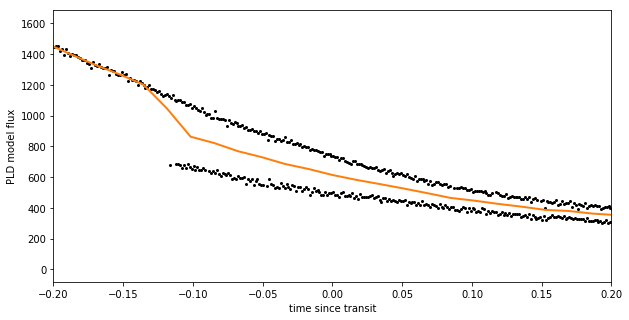

In [7]:
xs = []
ys = []
for tpf in tpf_all:
    pix_mask = tpf.create_threshold_mask(threshold=3)
    flux = tpf.flux
    
    lc = tpf.extract_aperture_photometry(aperture_mask=pix_mask, )
    lc = lc.normalize()
    lc.flux = (lc.flux - 1.0) * 1e3
    # Build the first order PLD basis
    X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
    X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

    # Build the second order PLD basis and run PCA to reduce the number of dimensions
    X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
    U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
    X2_pld = U[:, :X_pld.shape[1]]

    # Construct the design matrix and fit for the PLD model
    X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
    XTX = np.dot(X_pld.T, X_pld)
    w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, lc.flux))
    pld_flux = np.dot(X_pld, w_pld)

    # Plot the de-trended light curve
    plt.figure(figsize=(10, 5))
    plt.plot(lc.time, lc.flux-pld_flux, "k")
    plt.xlabel("time [days]")
    plt.ylabel("de-trended flux [ppt]")
    plt.title("initial de-trended light curve")
    plt.xlim(lc.time.min(), lc.time.max());
    
    period_grid = np.exp(np.linspace(np.log(0.1), np.log(15), 50000))
    duration = 0.03

    bls_periods = np.zeros([3])
    bls_t0s = np.zeros([3])
    bls_depths = np.zeros([3])
    time = lc.time - ref_time

    # planet 1
    bls = BoxLeastSquares(time, lc.flux - pld_flux)
    bls_power = bls.power(period_grid, duration, oversample=20)

    bls_power0 = bls_power

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    bls_period = bls_power.period[index]
    bls_t0 = bls_power.transit_time[index]
    bls_depth = bls_power.depth[index]
    transit_mask = bls.transit_mask(time, bls_period, 3*duration, bls_t0)

    bls_periods[0] = bls_period
    bls_t0s[0] = bls_t0
    bls_depths[0] = bls_depth

    # planet 2
    bls = BoxLeastSquares(time[~transit_mask], lc.flux[~transit_mask] - pld_flux[~transit_mask])
    bls_power = bls.power(period_grid, duration, oversample=20)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    bls_period = bls_power.period[index]
    bls_t0 = bls_power.transit_time[index]
    bls_depth = bls_power.depth[index]
    transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

    bls_periods[1] = bls_period
    bls_t0s[1] = bls_t0
    bls_depths[1] = bls_depth

    # planet 3
    bls = BoxLeastSquares(time[~transit_mask], lc.flux[~transit_mask] - pld_flux[~transit_mask])
    bls_power = bls.power(period_grid, duration, oversample=20)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    bls_period = bls_power.period[index]
    bls_t0 = bls_power.transit_time[index]
    bls_depth = bls_power.depth[index]
    transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

    bls_periods[2] = bls_period
    bls_t0s[2] = bls_t0
    bls_depths[2] = bls_depth
    
    fig, axes = plt.subplots(4, 1, figsize=(10, 10))

    # Plot the periodogram
    ax = axes[0]
    ax.axvline(np.log10(bls_periods[0]), color="C1", lw=5, alpha=0.8)
    ax.axvline(np.log10(bls_periods[1]), color="C1", lw=5, alpha=0.8)
    ax.axvline(np.log10(bls_periods[2]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_power0.period), bls_power0.power, "k")
    ax.annotate("periods = {0:.4f}, {1:.4f}, {2:.4f} d".format(*bls_periods),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    ax.set_xlabel("log10(period)")

    # Plot the folded transits
    bls = BoxLeastSquares(time, lc.flux - pld_flux)
    for i in range(3):
        ax = axes[i+1]
        x_fold = (time - bls_t0s[i] + 0.5*bls_periods[i])%bls_periods[i] - 0.5*bls_periods[i]
        m = np.abs(x_fold) < 0.4
        ax.plot(x_fold[m], lc.flux[m] - pld_flux[m], ".k")
        inds = np.argsort(x_fold[m])
        ax.plot(x_fold[m][inds], bls.model(time, bls_periods[i], duration, bls_t0s[i])[m][inds])

        # Overplot the phase binned light curve
        bins = np.linspace(-0.11, 0.11, 52)
        denom, _ = np.histogram(x_fold, bins)
        num, _ = np.histogram(x_fold, bins, weights=lc.flux - pld_flux)
        denom[num == 0] = 1.0
        ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

        ax.set_xlim(-0.1, 0.1)
        ax.set_ylabel("de-trended flux [ppt]")
        ax.set_xlabel("time since transit");
        
    m = ~transit_mask
    XTX = np.dot(X_pld[m].T, X_pld[m])
    w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, lc.flux[m]))
    pld_flux = np.dot(X_pld, w_pld)

    x = np.ascontiguousarray(lc.time-ref_time, dtype=np.float64)
    y = np.ascontiguousarray(lc.flux-pld_flux, dtype=np.float64)

    plt.figure(figsize=(10, 5))
    plt.plot(x, y, "k")
    plt.xlabel("time [days]")
    plt.ylabel("de-trended flux [ppt]")
    plt.title("final de-trended light curve")
    plt.xlim(x.min(), x.max());
    
    plt.figure(figsize=(10, 5))

    x_fold = (x - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period
    m = np.abs(x_fold) < 0.3
    plt.plot(x_fold[m], pld_flux[m], ".k", ms=4)

    bins = np.linspace(-0.5, 0.5, 60)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=pld_flux)
    denom[num == 0] = 1.0
    plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1", lw=2)
    plt.xlim(-0.2, 0.2)
    plt.xlabel("time since transit")
    plt.ylabel("PLD model flux");
    
    xs.append(x)
    ys.append(y)
    
 


In [8]:
def build_model(masks=None, start=None):
    bls_periods = [2.2529, 3.69018, 7.4508]
    bls_t0s = [-81.8839881893989, -80.77968818939894, -85.31728818939905]
    bls_depths = [0.6, 1.8, 1.8]
    if masks is None:
        masks = []
        for x in xs:
            mask = np.ones(len(x), dtype=bool)
            masks.append(mask)
    with pm.Model() as model:
        
        # constant parameters among all data sets
        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.3, 0.2]))
        R_star_kostov = 0.312, 0.015
        Rho_star_kostov = 15
        r_star = pm.Normal("r_star", mu=R_star_kostov[0], sd=R_star_kostov[1])
        logrho_star = pm.Normal("logrho_star", mu=np.log(Rho_star_kostov), sd=0.2)
        rho_star = pm.Deterministic("rho_star", tt.exp(logrho_star))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
        pm.Potential("rho_star_prior", tt.switch(rho_star > 0, 0, -np.inf))
        logP = pm.Normal("logP", mu=np.log(bls_periods), sd=0.2, shape=3)
        t0 = pm.Normal("t0", mu=bls_t0s, sd=0.2, shape=3)
        logror = pm.Normal("logror", mu=np.log(np.sqrt(1e-3)*np.sqrt(bls_depths)),
                           sd=2, shape=3)
        ror = pm.Deterministic("r", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=0, upper=1, shape=3)
        b = pm.Deterministic("b", b_param * (1 + ror))
        ecc = pm.Beta('ecc', alpha=0.867, beta=3.03, testval=[0.03, 0.02, 0.04], shape=3)
        omega = xo.distributions.Angle("omega", shape=3)
        pm.Potential("ror_prior_lo", tt.switch(tt.all(0.005 < ror), 0.0, -np.inf))
        pm.Potential("ror_prior_hi", tt.switch(tt.all(ror < 0.3), 0.0, -np.inf))
        
        
        
        period = pm.Deterministic("period", tt.exp(logP))
        r_pl = pm.Deterministic("r_pl", r_star * ror)
        r_ple = pm.Deterministic("r_ple", (r_star * ror / 0.009155))
        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, #m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega,
            rho_star=rho_star,
            )
        a = pm.Deterministic("a", orbit.a)
#         inc = pm.Deterministic("inc", orbit.inc)
        
        
        ####
        # Parameters for the stellar properties
        
        mean_0 = pm.Normal("mean_0".format(i), mu=0.0, sd=10.0)
        mean_1 = pm.Normal("mean_1".format(i), mu=0.0, sd=10.0)
        mean_2 = pm.Normal("mean_2".format(i), mu=0.0, sd=10.0)
           
        # Transit jitter & GP parameters
        logs2_0 = pm.Normal("logs2_0", mu=np.log(np.var(ys[0][masks[0]])), sd=10)
        logs2_1 = pm.Normal("logs2_1", mu=np.log(np.var(ys[1][masks[1]])), sd=10)
        logs2_2 = pm.Normal("logs2_2", mu=np.log(np.var(ys[2][masks[2]])), sd=10)
        
        logS0_0 = pm.Normal("logS0_0", mu=np.log(np.var(ys[0][masks[0]])), sd=10)
        logS0_1 = pm.Normal("logS0_1", mu=np.log(np.var(ys[1][masks[1]])), sd=10)
        logS0_2 = pm.Normal("logS0_2", mu=np.log(np.var(ys[2][masks[2]])), sd=10)
        
        logw0_0 = pm.Normal("logw0_0", mu=np.log(2*np.pi/10), sd=10)
        logw0_1 = pm.Normal("logw0_1", mu=np.log(2*np.pi/10), sd=10)
        logw0_2 = pm.Normal("logw0_2", mu=np.log(2*np.pi/10), sd=10)


        # Compute the model light curve using starry
        light_curves_0 = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=xs[0][masks[0]], texp=texp)*1e3
        light_curves_1 = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=xs[1][masks[1]], texp=texp)*1e3
        light_curves_2 = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=xs[2][masks[2]], texp=texp)*1e3
        
        light_curve_0 = pm.math.sum(light_curves_0, axis=-1)
        light_curve_1 = pm.math.sum(light_curves_1, axis=-1)
        light_curve_2 = pm.math.sum(light_curves_2, axis=-1)
        
        pm.Deterministic("light_curve_0", light_curve_0)
        pm.Deterministic("light_curve_1", light_curve_1)
        pm.Deterministic("light_curve_2", light_curve_2)
        
        model.light_curves_0 = light_curves_0
        model.light_curves_1 = light_curves_1
        model.light_curves_2 = light_curves_2

        # GP model for the light curve
        kernel_0 = xo.gp.terms.SHOTerm(log_S0=logS0_0, log_w0=logw0_0, Q=1/np.sqrt(2))
        kernel_1 = xo.gp.terms.SHOTerm(log_S0=logS0_1, log_w0=logw0_1, Q=1/np.sqrt(2))
        kernel_2 = xo.gp.terms.SHOTerm(log_S0=logS0_2, log_w0=logw0_2, Q=1/np.sqrt(2))
        
        gp_0 = xo.gp.GP(kernel_0, xs[0][masks[0]], tt.exp(logs2_0) + tt.zeros(masks[0].sum()), J=2)
        gp_1 = xo.gp.GP(kernel_1, xs[1][masks[1]], tt.exp(logs2_1) + tt.zeros(masks[1].sum()), J=2)
        gp_2 = xo.gp.GP(kernel_2, xs[2][masks[2]], tt.exp(logs2_2) + tt.zeros(masks[2].sum()), J=2)
        
        pm.Potential("transit_obs_0", gp_0.log_likelihood(ys[0][masks[0]] - light_curve_0 - mean_0))
        pm.Potential("transit_obs_1", gp_1.log_likelihood(ys[1][masks[1]] - light_curve_1 - mean_1))
        pm.Potential("transit_obs_2", gp_2.log_likelihood(ys[2][masks[2]] - light_curve_2 - mean_2))
        
        pm.Deterministic("gp_pred_0", gp_0.predict())
        pm.Deterministic("gp_pred_1", gp_1.predict())
        pm.Deterministic("gp_pred_2", gp_2.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[logs2_0, logs2_1, logs2_2,
                                                  logS0_0, logS0_1, logS0_2,
                                                  logw0_0, logw0_1, logw0_2])
#         map_soln = pm.find_MAP(start=map_soln, vars=[model.rb])
        map_soln = xo.optimize(start=map_soln, vars=[model.logror, model.b_param])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


optimizing logp for variables: ['logw0_2', 'logw0_1', 'logw0_0', 'logS0_2', 'logS0_1', 'logS0_0', 'logs2_2', 'logs2_1', 'logs2_0']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -63895.74731575728 -> -63740.783560569194
optimizing logp for variables: ['b_param_interval__', 'logror']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

message: Desired error not necessarily achieved due to precision loss.
logp: -63740.783560569194 -> -63324.39073018702
optimizing logp for variables: ['logw0_2', 'logw0_1', 'logw0_0', 'logS0_2', 'logS0_1', 'logS0_0', 'logs2_2', 'logs2_1', 'logs2_0', 'mean_2', 'mean_1', 'mean_0', 'omega_angle__', 'ecc_logodds__', 'b_param_interval__', 'logror', 't0', 'logP', 'logrho_star', 'r_star', 'u_star_quadlimbdark__']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

message: Desired error not necessarily achieved due to precision loss.
logp: -63324.390730187035 -> -62777.52486905753


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [9]:
masks = []
for i in range(3):
    mod = map_soln0["gp_pred_{}".format(i)] + map_soln0["mean_{}".format(i)] + map_soln0["light_curve_{}".format(i)]
    resid = ys[i] - mod
    rms = np.sqrt(np.median(resid**2))
    mask = np.abs(resid) < 5 * rms
    masks.append(mask)

In [10]:
model, map_soln = build_model(masks, map_soln0)

optimizing logp for variables: ['logw0_2', 'logw0_1', 'logw0_0', 'logS0_2', 'logS0_1', 'logS0_0', 'logs2_2', 'logs2_1', 'logs2_0']
message: Optimization terminated successfully.
logp: -61586.2826192735 -> -61559.000058380465
optimizing logp for variables: ['b_param_interval__', 'logror']
message: Optimization terminated successfully.
logp: -61559.00005838047 -> -61558.99310384634
optimizing logp for variables: ['logw0_2', 'logw0_1', 'logw0_0', 'logS0_2', 'logS0_1', 'logS0_0', 'logs2_2', 'logs2_1', 'logs2_0', 'mean_2', 'mean_1', 'mean_0', 'omega_angle__', 'ecc_logodds__', 'b_param_interval__', 'logror', 't0', 'logP', 'logrho_star', 'r_star', 'u_star_quadlimbdark__']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

message: Desired error not necessarily achieved due to precision loss.
logp: -61558.993103846355 -> -61558.94587117769


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [11]:
# np.savetxt('l98-59-s001lc.txt', np.array([x[mask], y[mask]]).T, delimiter=',')
print(ref_time)

1448.054788189399


In [12]:
with model:
    trace = pm.load_trace('.pymc_5.trace')[3000:]

In [13]:
trace

<MultiTrace: 4 chains, 2000 iterations, 38 variables>

In [127]:
# pm.summary(trace, varnames= ['b_param', 'logror', 't0', 'logP', 'ecc', 'omega','rho_star',
#            'logrho_star', 'r_star', 'u_star',  
#                              'logw0_0', 'logS0_0',
#                              'logs2_0', 'mean_0', 
#                              'logw0_1', 'logS0_1',
#                              'logs2_1', 'mean_1', 
#                              'r_ple', 'period'])

def trace_quantiles(x):
    return pd.DataFrame(pm.quantiles(x, [15, 50, 85]))

pm.summary(trace, start=0, varnames= [
 'r_star',
 'logrho_star',
 'logP',
 't0',
 'logror',
 'b_param',
 'mean_0',
 'mean_1',
 'mean_2',
 'logs2_0',
 'logs2_1',
 'logs2_2',
 'logS0_0',
 'logS0_1',
 'logS0_2',
 'logw0_0',
 'logw0_1',
 'logw0_2',
 'u_star',
 'rho_star',
 'r',
 'b_param',
 'b',
 'ecc',
 'omega',
 'period',
 'r_pl',
 'r_ple',
 'a'], alpha=0.32, stat_funcs=[trace_quantiles])

,15,50,85
r_star,0.296176,0.311840,0.327478
logrho_star,2.573889,2.758213,2.910763
logP__0,0.812318,0.812326,0.812334
logP__1,1.305791,1.305795,1.305798
logP__2,2.008323,2.008329,2.008334
t0__0,-81.885366,-81.884716,-81.884088
t0__1,-80.779591,-80.779254,-80.778902
t0__2,-85.317577,-85.316951,-85.316295
logror__0,-3.791952,-3.755527,-3.717432
logror__1,-3.249543,-3.227994,-3.200629


In [ ]:
samples = pm.trace_to_dataframe(trace, varnames=[
 'r_star',
 'logrho_star',
 'logP',
 't0',
 'logror',
 'b_param',
 'mean_0',
 'mean_1',
 'mean_2',
 'logs2_0',
 'logs2_1',
 'logs2_2',
 'logS0_0',
 'logS0_1',
 'logS0_2',
 'logw0_0',
 'logw0_1',
 'logw0_2',
 'u_star',
 'rho_star',
 'r',
 'b_param',
 'b',
 'ecc',
 'omega',
 'period',
 'r_pl',
 'r_ple',
 'a'])

In [133]:
np.percentile(samples.loc[:, ['t0__0','t0__1','t0__2']], [16,50,84], axis=0).T + ref_time

array([[1366.1694491 , 1366.17007159, 1366.17067381],
       [1367.27520918, 1367.27553464, 1367.27586922],
       [1362.73723279, 1362.73783735, 1362.73846388]])

In [19]:
q = np.percentile(samples.loc[:, ['logP__0', 'period__0', 'r__0', 'r_ple__0', 'a__0',]], [16,50,84], axis=0)

In [20]:
for i in range(7):
    print(q[0, i], q[1, i], q[2, i])

0.8123181188426698 0.8123258715368429 0.8123335255806006
2.253124948970083 2.2531424168264578 2.2531596625431076
0.02258367127971978 0.02338809945263969 0.024265305807074974
0.7494720146003957 0.7965443547969595 0.845764145147681
4.659608450846668 5.029095476759577 5.39989046814382


IndexError: index 5 is out of bounds for axis 1 with size 5

In [147]:
np.percentile(get_ar(samples.loc[:, 'rho_star'], samples.loc[:, 'period__1']), [16,50,84])

array([21.18255575, 22.4723688 , 23.5983124 ])

In [156]:
def get_ar(rho,period):
    """ gets a/R* from period and mean stellar density"""
    G = 6.67E-11
    rho_SI = rho * 1000.
    tpi = 3. * np.pi
    period_s = period * 86400.
    part1 = period_s**2 * G * rho_SI
    ar = (part1 / tpi)**(1./3.)
    return ar

def get_insol(teff, ars):
    return (teff/5778)**4 * (215.1/ars)**2

def get_inc(rho, period, b, ecc, omega):
    part1 = get_ar(rho, period)
    part2 = (1-ecc**2) / (1 + (ecc*np.sin(omega)))
    return np.arccos(b/part1 * part2**-1)
    

def get_duration(rho, period, ror, b, ecc, omega):
    part1 = period*86400 / np.pi
    part2 = get_ar(rho, period)
    part3 = ((1+ror)**2 - b**2)**0.5
    part4 = np.sin(get_inc(rho, period, b, ecc, omega))
    part5 = ((1-ecc**2)**0.5) / (1+(ecc*np.sin(omega)))
    
    return part1 * np.arcsin(part3 / (part2*part4)) / part5

In [144]:
np.percentile(get_ar(samples.loc[:, 'rho_star'], samples.loc[:, 'period__2']) *
              samples.loc[:, 'r_star'] / 215.9, [16,50,84])

array([0.04789421, 0.05169257, 0.05550369])

In [141]:
teff = np.random.normal(3500,150,size=samples.loc[:, 'rho_star'].shape[0])
np.percentile(get_insol(teff, get_ar(samples.loc[:, 'rho_star'], samples.loc[:, 'period__2'])),
              [16,50,84])

array([3.95658315, 4.85338134, 5.92930877])

In [154]:
np.percentile(get_inc(samples.loc[:, 'rho_star'],
                      samples.loc[:, 'period__2'],
                      samples.loc[:, 'b__2'],
                      samples.loc[:, 'ecc__2'],
                      samples.loc[:, 'omega__2']), [16,50,84]) * 180/np.pi

array([88.04192492, 88.45017832, 88.65452944])

In [161]:
np.percentile(get_duration(samples.loc[:, 'rho_star'],
                      samples.loc[:, 'period__2'],
                      samples.loc[:, 'r__2'],
                      samples.loc[:, 'b__2'],
                      samples.loc[:, 'ecc__2'],
                      samples.loc[:, 'omega__2']), [16,50,84]) / 3600

array([0.73647841, 0.90790343, 1.67979049])

In [25]:
with model:
    orbit = xo.orbits.KeplerianOrbit(
                r_star=0.117,
                period=1.51, t0=0, b=0.,
                rho_star=71.5, ecc=0., omega=0)
    print(xo.eval_in_model(orbit.a))

2.3987690077442667


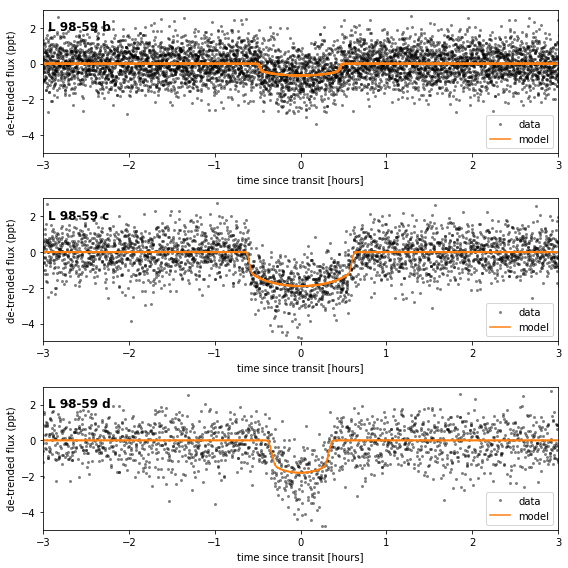

In [81]:
# Compute the GP prediction
gp_mod = np.r_[np.median(trace["gp_pred_0"] , axis=0),
               np.median(trace["gp_pred_1"] , axis=0),
               np.median(trace["gp_pred_2"] , axis=0),]

pletter = ['b', 'c', 'd']
fig,  axes = plt.subplots(3,1, figsize=[8, 8])
for i, pnum in enumerate([0,1,2]):
    ax1 = axes[i]
    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:,pnum])
    t0 = np.median(trace['t0'][:,pnum])

    # Plot the folded data
    
    xval = np.r_[xs[0][masks[0]], xs[1][masks[1]], xs[2][masks[2]]]
    yval = np.r_[ys[0][masks[0]], ys[1][masks[1]], ys[2][masks[2]]]

    x_fold = (xval - t0 + 0.5*p) % p - 0.5*p
    ax1.plot(x_fold * 24., yval - gp_mod, ".k", label="data",
             alpha=0.5, zorder=-1000, mec="none")

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    light_curves_0 = xo.utils.eval_in_model(model.light_curves_0, map_soln, model=model)
    light_curves_1 = xo.utils.eval_in_model(model.light_curves_1, map_soln, model=model)
    light_curves_2 = xo.utils.eval_in_model(model.light_curves_2, map_soln, model=model)
#     pred11, pred21, pred31 = np.percentile(np.add(trace['mean_0'], light_curves_0[:, pnum].T).T, [15, 50, 85], axis=0)
#     pred12, pred22, pred32 = np.percentile(np.add(trace['mean_1'], light_curves_1[:, pnum].T).T, [15, 50, 85], axis=0)
#     pred13, pred23, pred33 = np.percentile(np.add(trace['mean_2'], light_curves_2[:, pnum].T).T, [15, 50, 85], axis=0)


#     pred1 = np.r_[pred11, pred12, pred13][inds]
#     pred2 = np.r_[pred21, pred22, pred23][inds]
#     pred3 = np.r_[pred31, pred32, pred33][inds]
#     ax1.plot(x_fold[inds] * 24., pred2, color="C1", label="model")
#     art = ax1.fill_between(x_fold[inds] * 24., pred1, pred3, color="C1", alpha=0.3,
#                            zorder=1000)
#     art.set_edgecolor("none")

    pred2 = np.r_[light_curves_0[:,pnum] + np.median(trace['mean_0']), 
                  light_curves_1[:,pnum] + np.median(trace['mean_1']), 
                  light_curves_2[:,pnum] + np.median(trace['mean_2'])]

    ax1.plot(x_fold[inds] * 24., pred2[inds], color="C1", label="model")

    ax1.annotate('L 98-59 ' + pletter[i], (0., 0.8), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12, weight='bold')


    ax1.legend(fontsize=10, loc=4)
    ax1.set_xlabel("time since transit [hours]")
    ax1.set_ylabel("de-trended flux (ppt)")
    ax1.set_xlim(-3, 3);
    ax1.set_ylim(-5, 3);

plt.tight_layout()
plt.savefig('l98-transit-plot4.png', dpi=200)

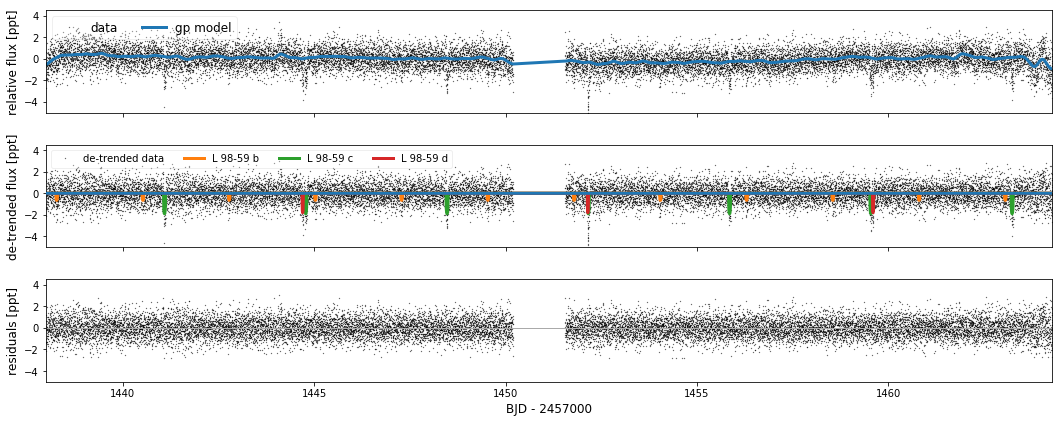

In [123]:
def plot_light_curve(model, soln, i=0):

    fig, axes = plt.subplots(3, 1, figsize=(15, 6), sharex=True, sharey=True)

    ax = axes[0]
    ax.plot(xs[i][masks[i]] + ref_time, ys[i][masks[i]], ".k", label="data", ms=0.5)
    if i == 0:
        mgp = model.gp_pred_0
        mlc = model.light_curves_0
    elif i == 1:
        mgp = model.gp_pred_1
        mlc = model.light_curves_1
    elif i == 2:
        mgp = model.gp_pred_2
        mlc = model.light_curves_2
    gp_mod = xo.utils.eval_in_model(mgp, soln, model=model)
    gp_mod += soln["mean_{}".format(i)]
    ax.plot(xs[i][masks[i]] + ref_time, gp_mod, color="C0", label="gp model", lw=3)
    ax.legend(fontsize=12, ncol=2, loc=2, framealpha=0.3)
    ax.set_ylabel("relative flux [ppt]", fontsize=12)
    ax.set_ylim(-5, 4.5)

    ax = axes[1]
    ax.plot(xs[i][masks[i]] + ref_time, ys[i][masks[i]] - gp_mod, ".k", label="de-trended data", ms=0.5, lw=3)
    ax.plot(xs[i][masks[i]] + ref_time, np.zeros_like(xs[i][masks[i]]), lw=3, zorder=1000)
    light_curves = xo.utils.eval_in_model(mlc, soln, model=model)
    for j, l in enumerate(["L 98-59 b", "L 98-59 c", "L 98-59 d"]):
        mod = light_curves[:, j]
        ax.plot(xs[i][masks[i]] + ref_time, mod, label="{0}".format(l), lw=3)
    ax.legend(fontsize=10, loc=2, ncol=4, framealpha=0.3)
    ax.set_ylabel("de-trended flux [ppt]", fontsize=12)
    ax.set_ylim(-5, 4.5)

    ax = axes[2]
    mod = gp_mod + np.sum(light_curves, axis=-1)
    ax.plot(xs[i][masks[i]] + ref_time, ys[i][masks[i]] - mod, ".k", ms=0.5)
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]", fontsize=12)
    ax.set_xlim(xs[i][masks[i]].min() + ref_time, xs[i][masks[i]].max() + ref_time)
    ax.set_xlabel("BJD - 2457000", fontsize=12)
    ax.set_ylim(-5, 4.5)
    fig.tight_layout()
    return fig
    
fig = plot_light_curve(model, map_soln, i=1);
fig.savefig('allplanets_s5.png', dpi=200)

In [190]:
4.45505882-3.71224913, 5.33216863-4.45505882

(0.7428096899999996, 0.8771098100000003)

In [15]:
trace["light_curve"]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

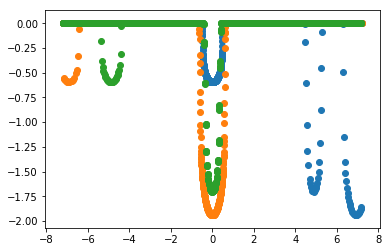

In [21]:
for i, pnum in enumerate([2,0,1]):
    p = np.median(trace["period"][:,pnum])
    t0 = np.median(trace['t0'][:,pnum])

    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curve"][:, inds]
    pred = np.percentile(pred, [5, 50, 95], axis=0)
    plt.scatter(x_fold[inds] * 24., pred[1], label="model")
#     plt.xlim(0,1)
    np.savetxt('planet{}-forknicole.csv'.format(i), np.array(
        [x_fold[inds][np.abs(x_fold[inds]) < 4], pred[1][np.abs(x_fold[inds]) < 4]]).T,
              delimiter=',')

In [18]:
x_fold[inds][np.abs(x_fold[inds]) < 4], 

array([-0.29976955, -0.29973747, -0.29966732, ...,  0.29886633,
        0.2989346 ,  0.29899743])

(4721,)

In [70]:
np.percentile(trace['logS0'], [16, 50,84])

array([-3.96137319, -3.53301891, -3.00698105])

In [69]:
0.5401176-0.72496427

-0.18484667